## Project Overview: Real-World Camera Calibration and Uncertainty Analysis

This project focuses on the intricate process of **camera calibration** and the application of **3D projection models**. The core objective is twofold: first, to accurately determine the geographic location (latitude, longitude, altitude) and intrinsic properties (calibration matrix K) of a camera given known 3D-to-2D point correspondences; second, to rigorously quantify the uncertainty and robustness of these estimations.

### Core Objectives:
*   **Estimate Camera Pose**: Determine the camera's 3D position (latitude, longitude, altitude) and orientation, as well as its intrinsic calibration matrix (K).
*   **Uncertainty Analysis**: Quantify the reliability of the camera parameter estimations through statistical methods.
*   **Real-World Application**: Apply calibration techniques to determine the 3D locations of live webcams.

### Tools Utilized:
*   **Python Libraries**: `pandas`, `matplotlib`, `pyproj`, `pymap3d`, `numpy`, `cv2` (OpenCV).
*   **Geospatial Software**: Google Earth Pro (for manual 3D coordinate extraction from real-world scenes).

You can use Google Earth Pro (Free download): https://earth.google.com/

### Part 1: Uncertainty Analysis with Synthetic Data

This section begins with a pre-provided dataset comprising 3D geographic coordinates (latitude, longitude, altitude) and their corresponding 2D pixel coordinates (x, y) on an image. The primary goal is to perform an in-depth uncertainty analysis of the calibration results.

**1a) Leave-One-Out (LOO) Analysis**
*   **Objective**: To assess the sensitivity of the estimated camera location to individual input data points. This helps identify the influence or potential instability caused by specific measurements.
*   **Methodology**: The camera calibration process is iteratively performed, each time excluding one data point from the original dataset. For a dataset of 'N' points, 'N' separate calibrations are executed.
*   **Expected Output**: A 3D point cloud visualization of the 'N' recovered camera locations. The spread of these points directly illustrates the impact of individual measurement exclusions on the estimated camera position.

**1b) Noise Analysis**
*   **Objective**: To evaluate the robustness and stability of the estimated camera parameters (location and focal length) under simulated measurement inaccuracies, mimicking real-world noise.
*   **Methodology**: The calibration process is executed 100 times. In each iteration, Gaussian zero-mean random noise is introduced to the input data:
    *   3D coordinates: Standard deviation of 1 meter.
    *   2D pixel locations: Standard deviation of 1 pixel.
*   **Expected Output**: A 3D point cloud visualization of the 100 recovered camera locations from the noisy examples, and a histogram illustrating the statistical distribution of the estimated camera focal lengths. This provides insight into how much the estimates can vary due to typical measurement errors.

### Part 2: Real-World Camera Calibration

This section applies the learned calibration and validation methodologies to real-world scenarios, specifically to determine the 3D geographic locations of live webcams.

**Steps Required & Methodology:**
1.  **Select Webcams**: Identify and choose live webcam streams for analysis. Example:
https://www.youtube.com/watch?v=5maZNtsWzeY, https://www.nps.gov/webcams-bost/ne-ts.jpeg
2.  **Landmark Identification**: Pinpoint distinct, recognizable features within the webcam's field of view that are also identifiable on satellite imagery.
3.  **Google Earth Pro Usage**: Utilize Google Earth Pro to precisely extract 3D geographic coordinates (latitude, longitude, altitude) for the identified landmarks. This involves aligning Google Earth's view with the webcam's perspective, placing placemarks using the 'little yellow pushpin' tool, and configuring altitude settings (e.g., 'altitude --> absolute' and 'track cursor height').
4.  **Coordinate Extraction**: Manually extract the longitude, latitude, and altitude data from the saved `.kml` files (opened as text).
5.  **2D Pixel Selection**: Record the corresponding 2D (x, y) pixel coordinates for each landmark directly from the webcam image.
6.  **Data Integration**: Compile the 3D and 2D coordinates into a structured CSV file (e.g., `bostonharbor.csv`).
7.  **Calibration & Validation**: Run the Python calibration code using the collected real-world data. The `gps_to_camxy` function is then used to reproject the 3D points back onto the image, generating a 'Reprojection Plot'. This plot visually validates the calibration by comparing manually picked pixel coordinates with the camera's predicted pixel locations for the same 3D points.
8.  **Iterative Refinement**: Based on the reprojection plot, refine landmark selections and coordinate extractions as needed to improve calibration accuracy.

**Expected Outputs for Part 2**:
*   A clear table or list of collected pixel coordinates and their matching 3D lat/long/alt coordinates.
*   The recovered 3D GPS location (latitude, longitude, altitude) for each calibrated camera.
*   A comprehensive discussion of the process, including any challenges encountered (e.g., matching viewpoints in Google Earth Pro, dynamic environments) and interesting observations.

---

**Companion Blog Post:**
For a detailed narrative, insights into our methodologies, and a discussion of the challenges and findings from this project, please refer to the companion blog post:
[https://medium.com/@anaswara.raghuthaman/blog-post-unveiling-the-hidden-world-calibrating-real-world-cameras-and-understanding-their-511e475f8cba](https://medium.com/@anaswara.raghuthaman/blog-post-unveiling-the-hidden-world-calibrating-real-world-cameras-and-understanding-their-511e475f8cba)


In [71]:
# You should not need to change this
#
# The next line suppresses output, otherwise you'd see a lot of install notifications.
%%capture
!pip install pandas matplotlib pyproj pymap3d

In [72]:
# You should not need to change this
#
# Import necessary libraries
import pandas as pd  # For data manipulation and reading CSV files
import matplotlib.pyplot as plt  # For plotting images and points
from pyproj import Transformer  # For coordinate system transformations (Geodetic <-> ECEF)
from PIL import Image  # For opening and handling image files
import pymap3d as pm  # For coordinate system transformations (ECEF <-> ENU)
import numpy as np  # For numerical operations, especially with arrays
import cv2  # OpenCV library for computer vision tasks like camera calibration and projection
import os  # For interacting with the operating system, like joining paths
import requests
from io import BytesIO

In [73]:
# YOU MAY want to change this to allow csv / images to be stored and accessed via your google drive
#
# Import the Google Colab drive library to mount Google Drive
#
# If you are running this notebook locally, you dont need this line
# from google.colab import drive

# Mount Google Drive to access files stored there
# This allows the notebook to read data from and write data to your Drive
# drive.mount('/content/drive')

## Setup Local coordinate system

In [74]:
# CHANGE THIS to define the local coordinate system origin (someplace near the camera).  Code I am sharing points this point near Madison Wisconsin.
#
# Define the GPS coordinates (latitude, longitude, altitude) approximately for the camera's origin point
# This point will serve as the reference for the local East-North-Up (ENU) coordinate system
origin_lat = 42.35733687571409     # Latitude of the origin point (e.g., camera location)
origin_lon = -71.04652412554964 # Longitude of the origin point
origin_alt = 0 + 204*0.3048     # Altitude of the origin point (calculated example: base + height in feet converted to meters)

# Store the origin GPS coordinates in a tuple
origin_gps = (origin_lat, origin_lon, origin_alt)

In [75]:
import pandas as pd


Boston_data = [
    [ 2154, 896, 42.35770186386652, 	-71.05035423977201, 	57.27096782675738 ],
    [ 972, 1190, 	42.35530571475373, 	-71.04666263990944, 	0 ],
    [ 1074, 1133, 	42.35411749677637, 	-71.05102384280451, 14.56236987124861 ],
    [ 2791, 1147, 	 42.36044597284898, 	-71.04812119529565, 	5.879197719190225 ],
    [ 1587, 1167, 	42.35608599130738, 	-71.04977859353858, 	0 ],
    [ 1686, 1170,    42.3563844082186,  -71.05016110607872,   31.63988169198878],
[ 1511, 1133,    42.35601354269201,  -71.04986963522853,   0]
]

poi_data = pd.DataFrame(Boston_data, columns=['img_x', 'img_y', 'map_lat', 'map_lng', 'map_altitude'])
poi_data.to_csv('bostonharbor.csv', index=False)  # Saves for reuse
display(poi_data.head(8))

,img_x,img_y,map_lat,map_lng,map_altitude
0,2154,896,42.357702,-71.050354,57.270968
1,972,1190,42.355306,-71.046663,0.000000
2,1074,1133,42.354117,-71.051024,14.562370
3,2791,1147,42.360446,-71.048121,5.879198
4,1587,1167,42.356086,-71.049779,0.000000
5,1686,1170,42.356384,-71.050161,31.639882
6,1511,1133,42.356014,-71.049870,0.000000


## Load the Points CSV

In [76]:
# Define the base directory where the data files are located in Google Drive
# Make sure this path matches the location of your files
# base_url = "/content/drive/MyDrive/homework3" # This variable might not be needed for the CSV path anymore

# Construct the full path to the CSV file containing point correspondences
# Using the raw content URL from GitHub for direct access
path_to_csv = '/content/bostonharbor.csv'

# Read the CSV file into a pandas DataFrame
# This file should contain columns for point ID, image coordinates (img_x, img_y),
# and corresponding map coordinates (map_lat, map_lng, map_altitude)
poi_data = pd.read_csv(path_to_csv)

# Display the first few rows of the DataFrame to verify it loaded  correctly
display(poi_data.head())

,img_x,img_y,map_lat,map_lng,map_altitude
0,2154,896,42.357702,-71.050354,57.270968
1,972,1190,42.355306,-71.046663,0.000000
2,1074,1133,42.354117,-71.051024,14.562370
3,2791,1147,42.360446,-71.048121,5.879198
4,1587,1167,42.356086,-71.049779,0.000000



# Let's plot some points

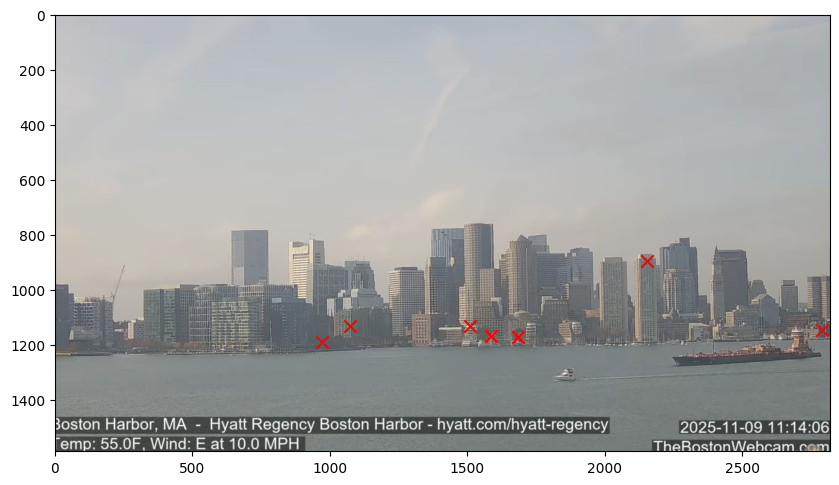

In [77]:
# Let's plot the x,y points we just read in on top of the image and make sure everything makes sense.

# Grab the x,y points we just read in from the CSV above and put it into a numpy array:
poi_xy = poi_data[['img_x', 'img_y']].to_numpy() # Shape: (N, 2)

# Now grab the image:
# If you have a local file, you can put the path here.
# default_img = Image.open("local path...")

# more complicated version to find it from a url:
img = cv2.imread('/Screenshot 2025-11-09 at 10.10.27 PM.png')

# If cv2.imread successfully loaded the image, convert it to PIL format
# cv2 reads images as BGR, PIL expects RGB
default_img = Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

# If you intended to load from a URL, uncomment the lines below and ensure 'img' is a URL string
# url = 'https://raw.githubusercontent.com/shrnik/contrails/main/uwisc/east/DEFAULT.jpg'
# response = requests.get(url)
# default_img = Image.open(BytesIO(response.content))

# Now create the figure:

# Create a figure for plotting
plt.figure(figsize=(10, 8)) # Adjust figure size as needed

# Display the background image
plt.imshow(default_img)

# Plot the original image points (from the input CSV) in red crosses
plt.scatter(poi_xy[:, 0], poi_xy[:, 1], c='red', s=80, marker='x', label='Original POIs (Input Data)')


# Utitlity Functions for Projection and Calibration
## YOU SHOULD NOT NEED TO CHANGE THIS

In [78]:
# Define transformation functions for coordinate systems.
# GPS is (lat, long, alt)
# ECEF is coordinates centered at the center of the earth
# ENU is local east nort up relative to a local origin

def gps_to_ecef(points_gps):
    """
    Converts an array of GPS points (latitude, longitude, altitude) to
    Earth-Centered, Earth-Fixed (ECEF) coordinates.

    Args:
        points_gps (np.ndarray): An Nx3 array where each row is [latitude, longitude, altitude].

    Returns:
        np.ndarray: An Nx3 array where each row is [ECEF_X, ECEF_Y, ECEF_Z].
    """
    # Define the transformation from Geodetic (EPSG:4979) to ECEF (EPSG:4978)
    # always_xy=True ensures the transformer expects (longitude, latitude) order
    transformer_geodetic_to_ecef = Transformer.from_crs(
        "epsg:4979", "epsg:4978", always_xy=True)

    # Perform the transformation
    # Note: pyproj expects longitude, latitude, altitude order for transform
    eX, eY, eZ = transformer_geodetic_to_ecef.transform(
        points_gps[:, 1], points_gps[:, 0], points_gps[:, 2])

    # Stack the results into an Nx3 NumPy array
    ecef_points = np.vstack((eX, eY, eZ)).T
    return ecef_points

def ecef_to_enu(origin_gps, points_ecef):
    """
    Converts ECEF coordinates to local East-North-Up (ENU) coordinates
    relative to a specified ECEF origin point.

    Args:
        origin_gps (np.ndarray): A 1x3 array representing the origin in GPS [latitude, longitude, altitude].
        points_ecef (np.ndarray): An Nx3 array of points in ECEF [X, Y, Z].

    Returns:
        np.ndarray: An Nx3 array of points in ENU [East, North, Up] relative to the origin.
    """
    lat0, lon0, alt0 = origin_gps

    # Use pymap3d to convert the ECEF points to ENU relative to the Geodetic origin
    east, north, up = pm.ecef2enu(points_ecef[:, 0], points_ecef[:, 1], points_ecef[:, 2],
                                  lat0, lon0, alt0)

    # Stack the results into an Nx3 NumPy array and transpose to get the correct shape
    return np.vstack((east, north, up)).T

def estimate_camera_params(poi_enu, poi_xy, frame_size, intrinsics_estimate=None, distortion_estimate=None):
    """
    Estimates camera intrinsic (K) and extrinsic (R, T) parameters using OpenCV's calibrateCamera.

    This function takes known 3D points in ENU coordinates and their corresponding 2D projections
    in the image to estimate the camera's properties.

    Args:
        poi_enu (np.ndarray): Nx3 array of Points of Interest (POIs) in ENU coordinates.
        poi_xy (np.ndarray): Nx2 array of corresponding image coordinates (pixels) for the POIs.
        frame_size (tuple): The (height, width) of the camera image in pixels.
        intrinsics_estimate (np.ndarray, optional): A 3x3 initial guess for the intrinsic matrix (K).
                                                    If None, a default guess based on frame size is used.
        distortion_estimate (np.ndarray, optional): A 5x1 initial guess for distortion coefficients.
                                                     If None, zeros are used.

    Returns:
        tuple: (camera_matrix, dist_coeffs, R, T)
            camera_matrix (np.ndarray): The estimated 3x3 intrinsic matrix (K).
            dist_coeffs (np.ndarray): The estimated 5x1 distortion coefficients.
            R (np.ndarray): The estimated 3x3 rotation matrix (world/ENU to camera).
            T (np.ndarray): The estimated 3x1 translation vector (world/ENU to camera).
    """

    # --- Step 1: Prepare Data for OpenCV ---
    # Ensure arrays are contiguous and have the correct types for OpenCV functions.
    object_points = np.ascontiguousarray(poi_enu, dtype=np.float32) # (N, 3) - 3D points in ENU
    image_points = np.ascontiguousarray(poi_xy, dtype=np.float32)   # (N, 2) - 2D projections

    # --- Step 2: Set Initial Guesses and Parameters for Calibration ---
    # If no initial intrinsic guess is provided, create a basic one.
    # Assumes focal length is large and principal point is image center.
    if intrinsics_estimate is None:
        # A large initial focal length guess can sometimes help convergence.
        estimated_focal_dist = max(frame_size) * 1.5 # Example heuristic
        intrinsics_estimate = np.array([
            [estimated_focal_dist, 0, frame_size[1] / 2], # fx, 0, cx
            [0, estimated_focal_dist, frame_size[0] / 2], # 0, fy, cy
            [0, 0, 1]
        ], dtype=np.float32)

    # If no initial distortion guess is provided, assume no distortion.
    if distortion_estimate is None:
        distortion_estimate = np.zeros((5, 1), dtype=np.float32)

    # Define termination criteria for the iterative optimization process.
    # Use stricter criteria than default for potentially better accuracy.
    criteria = (
        cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER,
        10000,    # Max iterations
        1e-12     # Epsilon (convergence tolerance)
    )

    # Print initial guesses for debugging/information
    print("Initial intrinsics guess:\n", intrinsics_estimate)
    print("Initial distortion guess:\n", distortion_estimate.ravel())

    # Define flags to control the calibration process.
    # CALIB_USE_INTRINSIC_GUESS: Start optimization from the provided intrinsic estimate.
    # CALIB_FIX_PRINCIPAL_POINT: Keep cx, cy fixed. Often reasonable if the center is well-known.
    # CALIB_FIX_ASPECT_RATIO: Keep fx/fy ratio fixed. Common for modern cameras.
    # CALIB_ZERO_TANGENT_DIST: Assume tangential distortion (p1, p2) is zero. Often a safe assumption.
    # CALIB_FIX_K[4,5,6]: Do not estimate higher-order radial distortion coefficients.
    calibrate_flags = (
        cv2.CALIB_USE_INTRINSIC_GUESS |
        cv2.CALIB_FIX_PRINCIPAL_POINT |
        cv2.CALIB_FIX_ASPECT_RATIO |
        cv2.CALIB_ZERO_TANGENT_DIST |
        cv2.CALIB_FIX_K1 | cv2.CALIB_FIX_K2 | cv2.CALIB_FIX_K3 |
        cv2.CALIB_FIX_K4 | cv2.CALIB_FIX_K5 | cv2.CALIB_FIX_K6
        # Note: CALIB_USE_EXTRINSIC_GUESS is removed as we don't provide R, T guesses here.
    )

    # --- Step 3: Perform Camera Calibration ---
    # calibrateCamera requires objectPoints and imagePoints to be lists of arrays (one per view).
    # Since we only have one view, we wrap them in lists.
    ret, camera_matrix, dist_coeffs, rvecs, tvecs = cv2.calibrateCamera(
        [object_points],      # List containing the Nx3 object points array
        [image_points],       # List containing the Nx2 image points array
        (frame_size[1], frame_size[0]), # frame_size expected as (width, height) by OpenCV
        intrinsics_estimate,  # Initial intrinsic guess
        distortion_estimate,  # Initial distortion guess
        flags=calibrate_flags,
        criteria=criteria
    )

    # --- Step 6: Extract and Format Results ---
    # calibrateCamera returns lists of rvecs and tvecs (one per view). Get the first element.
    t_vector = tvecs[0]
    # Convert the returned rotation vector (Rodrigues) back to a 3x3 rotation matrix.
    r_matrix, _ = cv2.Rodrigues(rvecs[0])

    # Check the return value (ret) which indicates success/quality (reprojection error)
    print(f"Calibration reprojection error: {ret}")

    # Return the estimated parameters and the camera origin in ECEF
    return camera_matrix, dist_coeffs, r_matrix, t_vector

def gps_to_camxy(points_gps, cam_k, cam_r, cam_t, camera_gps_origin, distortion=None):
    """
    Projects GPS points (latitude, longitude, altitude) onto the camera's image plane.

    This function converts GPS coordinates to ECEF, then to ENU relative to the camera origin,
    then transforms ENU points to the camera's coordinate system, and finally projects
    them onto the 2D image plane using camera intrinsics, extrinsics, and distortion coefficients.

    Args:
        points_gps (np.ndarray): An Nx3 array of GPS points [latitude, longitude, altitude].
        cam_k (np.ndarray): 3x3 camera intrinsic matrix (K).
        cam_r (np.ndarray): 3x3 camera rotation matrix (R) transforming ENU to Camera coords.
        cam_t (np.ndarray): 3x1 camera translation vector (T) transforming ENU to Camera coords.
        camera_gps_origin (tuple): The (latitude, longitude, altitude) of the camera origin.
        distortion (np.ndarray, optional): Camera distortion coefficients (k1, k2, p1, p2, k3). Defaults to None (no distortion).

    Returns:
        tuple: (image_x, image_y, cam_distance)
            image_x (np.ndarray): Array of projected x-coordinates in the image (pixels). NaN if point is behind camera.
            image_y (np.ndarray): Array of projected y-coordinates in the image (pixels). NaN if point is behind camera.
            cam_distance (np.ndarray): Array of distances (Z-coordinate) of points in the camera coordinate system.
    """


    # --- Step 1: Convert Input GPS points to ECEF ---
    # Convert all GPS points to ECEF using the dedicated function
    ecef_points = gps_to_ecef(points_gps) # Shape: (N, 3)
    num_points = ecef_points.shape[0]

    # --- Step 2: Convert ECEF points to ENU relative to Camera Origin ---
    # Convert ECEF points to local ENU coordinates using the camera's ECEF position as the origin
    enu_points = ecef_to_enu(camera_gps_origin, ecef_points) # Shape: (N, 3)

    # --- Step 3: Transform ENU points to Camera Coordinate System ---
    # Apply rotation (R) and translation (T) to transform ENU points to the camera's coordinate system.
    # Camera coordinates: X=right, Y=down, Z=forward (into scene)
    # Formula: P_cam = R * P_enu + T
    # We transpose enu_points for matrix multiplication and then transpose back.
    points_cam = (cam_r @ enu_points.T + cam_t).T # Shape: (N, 3)

    # --- Step 4: Handle Points Behind the Camera ---
    # Identify points with Z <= 0, which are behind the camera's image plane.
    behind_camera_mask = points_cam[:, 2] <= 0

    # --- Step 5: Project Points onto Image Plane using OpenCV ---
    # Initialize output arrays with NaN. NaN will remain for points behind the camera.
    image_x = np.full(num_points, np.nan)
    image_y = np.full(num_points, np.nan)
    # The Z coordinate in the camera system represents the distance along the camera's optical axis.
    cam_distance = points_cam[:, 2]

    # Only project points that are in front of the camera (Z > 0)
    valid_points_mask = ~behind_camera_mask
    if np.any(valid_points_mask):
        # Select only the valid ENU points for projection
        enu_points_to_project = enu_points[valid_points_mask]

        # OpenCV's projectPoints function requires:
        # - Object points (in the world/ENU frame for solvePnP/calibrateCamera, but here R and T already map ENU to Cam)
        #   However, projectPoints applies R and T itself. It expects world points, R, T that map world to camera.
        #   Since our R and T map ENU (our 'world' relative to camera origin) to Camera, we provide ENU points.
        # - Rotation vector (rvec): Rodrigues representation of cam_r (world-to-camera rotation)
        # - Translation vector (tvec): cam_t (world-to-camera translation)
        # - Camera matrix (cam_k)
        # - Distortion coefficients (distortion)

        # Convert the 3x3 rotation matrix to a rotation vector (Rodrigues format)
        rvec, _ = cv2.Rodrigues(cam_r)
        # Ensure tvec is float32
        tvec = cam_t.astype(np.float32)

        # If no distortion coefficients are provided, use zeros
        if distortion is None:
            distortion = np.zeros((5, 1), dtype=np.float32)

        # Project the valid 3D points (in ENU) onto the 2D image plane
        image_points, _ = cv2.projectPoints(
            enu_points_to_project.astype(np.float32), # Object points (Nx3)
            rvec,                                      # Rotation vector (3x1)
            tvec,                                      # Translation vector (3x1)
            cam_k,                                     # Camera matrix (3x3)
            distortion                                 # Distortion coefficients (5x1)
        )
        # Reshape the output image points from (N, 1, 2) to (N, 2)
        image_points = image_points.reshape(-1, 2)

        # Assign the calculated image coordinates back to the corresponding original indices
        valid_indices = np.where(valid_points_mask)[0]
        image_x[valid_indices] = image_points[:, 0]
        image_y[valid_indices] = image_points[:, 1]

    # Return the projected x, y coordinates and the camera-frame distances (Z)
    return image_x, image_y, cam_distance

In [79]:
def calculate_fov_from_intrinsics(intrinsics, image_width, image_height):
    """
    Calculate horizontal and vertical field of view (FOV) in degrees
    from the camera intrinsic matrix (K).

    **NOTE:** This calculation assumes a simple pinhole camera model without lens distortion.
             The FOV might differ if significant distortion is present.

    Args:
        intrinsics (np.ndarray): 3x3 camera intrinsic matrix (K).
        image_width (int): Width of the image in pixels.
        image_height (int): Height of the image in pixels.

    Returns:
        tuple: (hfov_deg, vfov_deg)
            hfov_deg (float): Horizontal field of view in degrees.
            vfov_deg (float): Vertical field of view in degrees.
    """
    # Extract focal lengths (fx, fy) and principal point (cx, cy) from the intrinsic matrix
    fx = intrinsics[0, 0]  # Focal length in x-direction (pixels)
    fy = intrinsics[1, 1]  # Focal length in y-direction (pixels)
    cx = intrinsics[0, 2]  # Principal point x-coordinate (pixels)
    cy = intrinsics[1, 2]  # Principal point y-coordinate (pixels)

    # Calculate horizontal FOV
    # Angle from optical center to the left edge + angle from optical center to the right edge
    # tan(angle_left) = cx / fx
    angle_left = np.arctan(cx / fx)
    # tan(angle_right) = (image_width - cx) / fx
    angle_right = np.arctan((image_width - cx) / fx)
    hfov_rad = angle_left + angle_right # Total horizontal FOV in radians

    # Calculate vertical FOV
    # Angle from optical center to the top edge + angle from optical center to the bottom edge
    # tan(angle_top) = cy / fy
    angle_top = np.arctan(cy / fy)
    # tan(angle_bottom) = (image_height - cy) / fy
    angle_bottom = np.arctan((image_height - cy) / fy)
    vfov_rad = angle_top + angle_bottom # Total vertical FOV in radians

    # Convert radians to degrees
    hfov_deg = np.degrees(hfov_rad)
    vfov_deg = np.degrees(vfov_rad)

    # Return FOV in degrees
    return (hfov_deg, vfov_deg)

# Initial Camera Intrinsic Matrix

In [80]:
# --- Initial Camera Intrinsic Matrix (K) Guess ---

# Define an initial guess for the camera's vertical field of view (FOV) in degrees.
# This is often known approximately from camera specifications or can be estimated.
vfov_deg_estimate = 63.59 # Example estimated vertical FOV

# Get image dimensions (height, width)
frame_size = (default_img.height, default_img.width) # OpenCV uses (height, width)

# Calculate an initial guess for the focal length (in pixels) based on the vertical FOV estimate.
# Assumes the principal point is roughly centered (cy = height / 2).
# Formula derived from pinhole model: tan(vfov / 2) = (height / 2) / fy
# Rearranging gives: fy = (height / 2) / tan(vfov / 2)
focal_length_estimate = 0.5 * frame_size[0] / np.tan(0.5 * np.radians(vfov_deg_estimate))

# Create the initial guess for the 3x3 intrinsic matrix K.
# Assumes square pixels (fx = fy) and principal point at the image center.
initial_k = np.array([
    [focal_length_estimate, 0, frame_size[1] / 2], # [fx, 0, cx]
    [0, focal_length_estimate, frame_size[0] / 2], # [0, fy, cy]
    [0, 0, 1]
], dtype=np.float32)

# Prepare Data for Calibration

In [81]:

# Extract 2D image coordinates (poi_xy) from the DataFrame
poi_xy = poi_data[['img_x', 'img_y']].to_numpy() # Shape: (N, 2)

# Extract 3D GPS coordinates (poi_gps) from the DataFrame
poi_gps = poi_data[['map_lat', 'map_lng', 'map_altitude']].to_numpy() # Shape: (N, 3)

# Convert the 3D GPS coordinates to ECEF coordinates
poi_ecef = gps_to_ecef(poi_gps) # Shape: (N, 3)

origin_ecef = gps_to_ecef(np.array([origin_gps])) # Shape: (1, 3)

poi_enu = ecef_to_enu(origin_gps, poi_ecef)

all_poi_ecef = poi_ecef
all_poi_enu = poi_enu
all_poi_xy = poi_xy


# Perform Camera Calibration

In [82]:
# Call the estimation function with the prepared 3D ECEF points, 2D image points,
# camera origin GPS, frame size, and the initial intrinsic matrix guess.
# Distortion is initially set to None, allowing estimate_camera_params to use zeros or estimate it.
k_matrix, dist_coeffs, r_matrix, t_vector = estimate_camera_params(
    poi_enu=all_poi_enu,                 # 3D points in ENU
    poi_xy=all_poi_xy,                 # Corresponding 2D points in image
    frame_size=frame_size,             # Image dimensions (height, width)
    intrinsics_estimate=initial_k,     # Initial guess for K matrix
    distortion_estimate=None           # Initial guess for distortion (use zeros)
)

# --- Output Estimated Parameters ---
# The function estimate_camera_params already prints the initial guesses and reprojection error.
# Now, print the final estimated parameters.
print("\n--- Estimated Camera Parameters ---")
print("Intrinsic Matrix (K):\n", k_matrix)
print("Distortion Coefficients (D):\n", dist_coeffs.ravel()) # Flatten for easier reading
print("Rotation Matrix (R - ENU to Camera):\n", r_matrix)
print("Translation Vector (T - ENU to Camera):\n", t_vector.ravel())

# --- Calculate and Output Estimated FOV ---
# Calculate the horizontal and vertical FOV from the estimated intrinsic matrix
hfov, vfov = calculate_fov_from_intrinsics(k_matrix, frame_size[1], frame_size[0])
print(f"\nEstimated Horizontal FOV: {hfov:.2f} degrees")
print(f"Estimated Vertical FOV: {vfov:.2f} degrees")

Initial intrinsics guess:
 [[1.2808405e+03 0.0000000e+00 1.4100000e+03]
 [0.0000000e+00 1.2808405e+03 7.9400000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 123.28053816905432

--- Estimated Camera Parameters ---
Intrinsic Matrix (K):
 [[2.30813241e+05 0.00000000e+00 1.41000000e+03]
 [0.00000000e+00 2.30813241e+05 7.94000000e+02]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion Coefficients (D):
 [0. 0. 0. 0. 0.]
Rotation Matrix (R - ENU to Camera):
 [[-0.37975712  0.90898904  0.17182393]
 [ 0.23242524 -0.08602773  0.96880222]
 [ 0.89541222  0.40784575 -0.17860235]]
Translation Vector (T - ENU to Camera):
 [   80.93882183   197.43425136 74011.66728327]

Estimated Horizontal FOV: 0.70 degrees
Estimated Vertical FOV: 0.39 degrees


# Reproject Points and Visualize Results

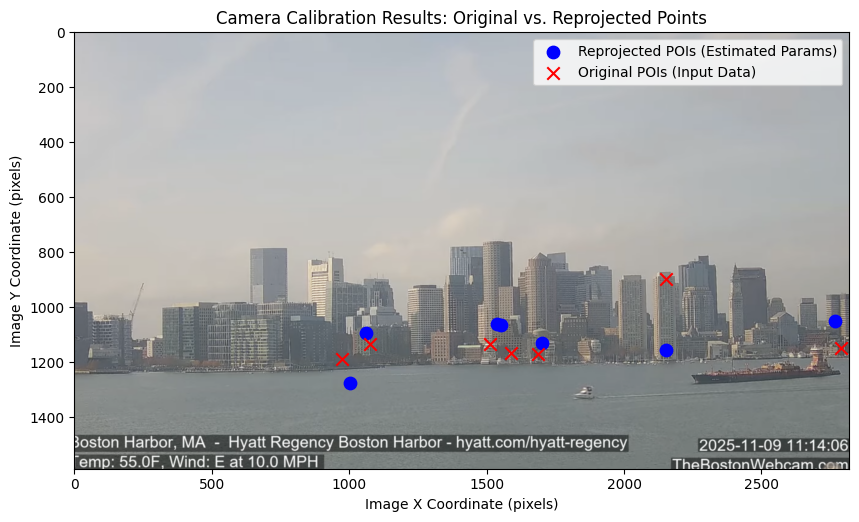

In [83]:

# Use the estimated camera parameters (k_matrix, dist_coeffs, r_matrix, t_vector, cam_ecef_origin)
# to project the original 3D GPS points back onto the 2D image plane.
# This helps visualize the accuracy of the calibration.
image_x_reprojected, image_y_reprojected, cam_distance = gps_to_camxy(
    points_gps=poi_gps,
    cam_k=k_matrix,                    # Estimated K matrix
    cam_r=r_matrix,                    # Estimated R matrix
    cam_t=t_vector,                    # Estimated T vector
    camera_gps_origin=origin_gps,      # Camera origin GPS used in calibration
    distortion=dist_coeffs             # Estimated distortion coefficients
)

# --- Plot the Original and Reprojected Points on the Image ---

# Create a figure for plotting
plt.figure(figsize=(10, 8)) # Adjust figure size as needed

# Display the background image
plt.imshow(default_img)

# Plot the reprojected points (calculated using the estimated parameters) in blue circles
plt.scatter(image_x_reprojected, image_y_reprojected, c='blue', s=80, marker='o', label='Reprojected POIs (Estimated Params)')

# Plot the original image points (from the input CSV) in red crosses
plt.scatter(all_poi_xy[:, 0], all_poi_xy[:, 1], c='red', s=80, marker='x', label='Original POIs (Input Data)')

# Add labels, title, and legend for clarity
plt.title('Camera Calibration Results: Original vs. Reprojected Points')
plt.xlabel('Image X Coordinate (pixels)')
plt.ylabel('Image Y Coordinate (pixels)')
plt.legend() # Show the legend based on the labels provided in scatter plots

# Optionally set limits if needed, e.g., plt.xlim([0, frame_size[1]]), plt.ylim([frame_size[0], 0])
# Set Y-axis limits to match image height, inverted because image origin is top-left
plt.ylim([frame_size[0], 0])
# Set X-axis limits to match image width
plt.xlim([0, frame_size[1]])

# Display the plot
plt.show()

## Define Camera GPS Recovery Function

### Subtask:
Create a new Python function that takes the `origin_gps` (the ENU reference point), the estimated camera `r_matrix` (rotation from ENU to Camera), and `t_vector` (translation from ENU to Camera), and calculates the camera's GPS (latitude, longitude, altitude) coordinates. This will involve inverting the ENU to Camera transformation to find the camera's position in the ENU frame, and then converting that ENU position back to ECEF and finally to GPS.


# Task
To perform the analysis, I need to add a utility function `camera_enu_to_gps` to convert the estimated camera pose (rotation and translation from ENU to Camera) back to GPS coordinates. This function will be crucial for both the Leave-One-Out and Noise analyses.

Here's the new code:
```python
def camera_enu_to_gps(origin_gps, r_matrix, t_vector):
    """
    Recovers the camera's GPS location (latitude, longitude, altitude)
    from its estimated extrinsic parameters (R, T) relative to an ENU origin.

    Args:
        origin_gps (tuple): The (latitude, longitude, altitude) of the ENU origin.
        r_matrix (np.ndarray): The 3x3 rotation matrix from ENU to Camera coordinates.
        t_vector (np.ndarray): The 3x1 translation vector from ENU to Camera coordinates.

    Returns:
        tuple: The camera's estimated GPS location (latitude, longitude, altitude).
    """
    # 1. Invert the ENU to Camera transformation to find the camera's position in ENU.
    # P_cam = R * P_enu + T
    # The camera's origin in its own frame is (0, 0, 0). So, 0 = R * P_enu_camera + T
    # P_enu_camera = R_inv * (-T) = R_transpose * (-T)
    cam_enu_pos = r_matrix.T @ (-t_vector)

    # 2. Convert the camera's ENU position to ECEF using the origin_gps.
    origin_lat, origin_lon, origin_alt = origin_gps
    cam_ecef_x, cam_ecef_y, cam_ecef_z = pm.enu2ecef(
        cam_enu_pos[0, 0], cam_enu_pos[1, 0], cam_enu_pos[2, 0],
        origin_lat, origin_lon, origin_alt
    )
    cam_ecef_pos = np.array([cam_ecef_x, cam_ecef_y, cam_ecef_z])

    # 3. Convert ECEF to GPS (latitude, longitude, altitude).
    transformer_ecef_to_geodetic = Transformer.from_crs(
        "epsg:4978", "epsg:4979", always_xy=True) # ECEF to Geodetic
    # pyproj expects (longitude, latitude, altitude) for transform when always_xy=True
    cam_lon, cam_lat, cam_alt = transformer_ecef_to_geodetic.transform(
        cam_ecef_pos[0], cam_ecef_pos[1], cam_ecef_pos[2]
    )

    return (cam_lat, cam_lon, cam_alt)
```

**Reasoning**:
The subtask requires defining a new Python function `camera_enu_to_gps`. This function will perform the inverse transformation from camera coordinates to ENU, then convert from ENU to ECEF, and finally from ECEF to GPS, as detailed in the instructions.



In [43]:
import numpy as np
from pyproj import Transformer
import pymap3d as pm

def camera_enu_to_gps(origin_gps, r_matrix, t_vector):
    """
    Calculates the camera's GPS coordinates (latitude, longitude, altitude)
    from the camera's extrinsic parameters (rotation and translation) relative
    to a local ENU origin.

    Args:
        origin_gps (tuple): The GPS coordinates (lat, lon, alt) of the ENU origin point.
        r_matrix (np.ndarray): The 3x3 rotation matrix from ENU to Camera coordinates.
        t_vector (np.ndarray): The 3x1 translation vector from ENU to Camera coordinates.

    Returns:
        tuple: (camera_lat, camera_lon, camera_alt) in degrees and meters.
    """

    # Unpack the origin GPS coordinates
    lat0, lon0, alt0 = origin_gps

    # Step 1: Invert the camera transformation to find the camera's position in ENU
    # P_cam = R @ P_enu + T  =>  P_enu = R.T @ (P_cam - T)
    # The camera's position in its own frame (P_cam) is (0,0,0).
    # So, cam_enu_pos = R.T @ (0 - T) = R.T @ (-T)
    cam_enu_pos_vector = r_matrix.T @ (-t_vector)

    # Flatten the result to get scalar E, N, U components for pymap3d
    e_cam, n_cam, u_cam = cam_enu_pos_vector.flatten()

    # Step 2: Convert cam_enu_pos from ENU to ECEF using the origin_gps
    ecef_x, ecef_y, ecef_z = pm.enu2ecef(e_cam, n_cam, u_cam, lat0, lon0, alt0)

    # Step 3: Convert the resulting ECEF coordinates to GPS (latitude, longitude, altitude)
    # Define the transformation from ECEF (EPSG:4978) to Geodetic (EPSG:4979)
    # always_xy=True ensures the transformer returns (longitude, latitude)
    transformer_ecef_to_geodetic = Transformer.from_crs(
        "epsg:4978", "epsg:4979", always_xy=True)

    # Perform the transformation
    # Note: pyproj returns (longitude, latitude, altitude) if always_xy=True
    cam_lon, cam_lat, cam_alt = transformer_ecef_to_geodetic.transform(
        ecef_x, ecef_y, ecef_z)

    # Return the camera's GPS coordinates
    return cam_lat, cam_lon, cam_alt

print("Defined camera_enu_to_gps function.")

Defined camera_enu_to_gps function.


## Perform Leave-One-Out (LOO) Analysis

### Subtask:
Implement a loop that iterates through each point in the `poi_data`. In each iteration, temporarily remove one point from the dataset. Use the remaining points to recalibrate the camera (calling `estimate_camera_params`). Store the resulting estimated camera GPS location using the helper function defined in the previous step. Collect all these estimated camera GPS locations.


**Reasoning**:
The subtask requires implementing a Leave-One-Out (LOO) analysis. This involves iterating through each point, recalibrating the camera with the remaining data, and collecting the estimated camera GPS locations for each iteration.



In [44]:
loo_camera_locations = []

# Get the total number of points
num_points = len(all_poi_enu)

# Iterate through each point for Leave-One-Out analysis
for i in range(num_points):
    # Temporarily remove one point from the dataset
    loo_poi_enu = np.delete(all_poi_enu, i, axis=0)
    loo_poi_xy = np.delete(all_poi_xy, i, axis=0)

    # Recalibrate the camera with the reduced dataset
    # Use the same initial_k and frame_size as the full calibration
    k_matrix_loo, dist_coeffs_loo, r_matrix_loo, t_vector_loo = estimate_camera_params(
        poi_enu=loo_poi_enu,
        poi_xy=loo_poi_xy,
        frame_size=frame_size,
        intrinsics_estimate=initial_k,
        distortion_estimate=None
    )

    # Convert the estimated camera pose back to GPS coordinates
    camera_lat_loo, camera_lon_loo, camera_alt_loo = camera_enu_to_gps(
        origin_gps,
        r_matrix_loo,
        t_vector_loo
    )

    # Store the estimated GPS location
    loo_camera_locations.append([camera_lat_loo, camera_lon_loo, camera_alt_loo])

# Convert the list of GPS locations to a NumPy array
loo_camera_locations = np.array(loo_camera_locations)

print("Leave-One-Out analysis complete. Collected", len(loo_camera_locations), "camera GPS locations.")
print("First 5 LOO camera GPS locations:")
print(loo_camera_locations[:5])

Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 40.3927635665427
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 41.92456862312485
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 21.504313099911876
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojecti

## Visualize LOO Camera Locations

### Subtask:
Create a 3D scatter plot using `matplotlib` to visualize all the camera GPS locations obtained from the Leave-One-Out analysis. The plot should show the spread and variability of the camera's estimated position when individual points are removed. Ensure appropriate labels for the axes (e.g., Latitude, Longitude, Altitude) and a title for the plot.


**Reasoning**:
The subtask requires creating a 3D scatter plot of the `loo_camera_locations` to visualize the spread and variability of the camera's estimated position. This involves importing `mpl_toolkits.mplot3d` for 3D plotting, setting up a figure and 3D axes, plotting the data, and labeling the axes with a title.



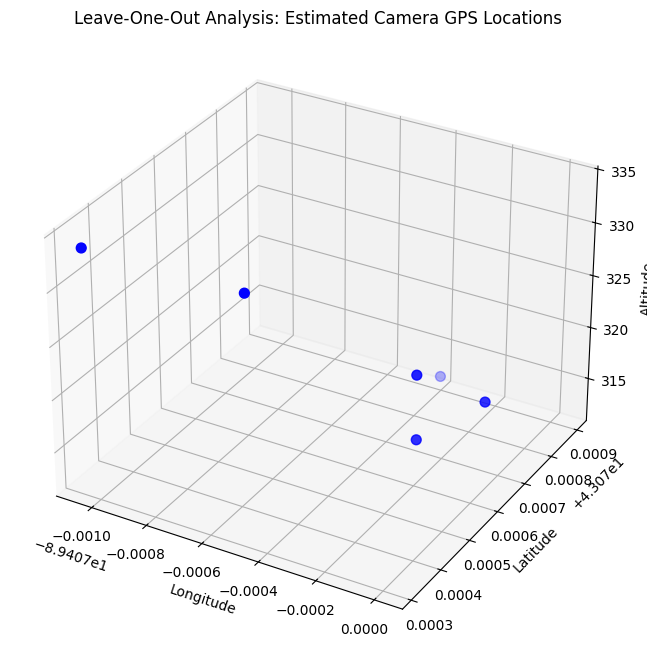

3D scatter plot of LOO camera locations displayed.


In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a new figure for the 3D plot
fig = plt.figure(figsize=(10, 8))
# Add a 3D subplot to the figure
ax = fig.add_subplot(111, projection='3d')

# Extract latitude, longitude, and altitude from loo_camera_locations
# Assuming loo_camera_locations is an N x 3 array where columns are [latitude, longitude, altitude]
longitudes = loo_camera_locations[:, 1]
latitudes = loo_camera_locations[:, 0]
altitudes = loo_camera_locations[:, 2]

# Create the 3D scatter plot
# Longitude on x-axis, Latitude on y-axis, Altitude on z-axis
ax.scatter(longitudes, latitudes, altitudes, c='blue', marker='o', s=50)

# Set labels for the axes
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Altitude')

# Set the title of the plot
ax.set_title('Leave-One-Out Analysis: Estimated Camera GPS Locations')

# Display the plot
plt.show()
print("3D scatter plot of LOO camera locations displayed.")

## Perform Noise Analysis

### Subtask:
Run a simulation for 100 iterations. In each iteration: 1. Generate Gaussian noise with a standard deviation of 1 meter for the 3D `poi_enu` coordinates and 1 pixel for the 2D `poi_xy` coordinates. 2. Add this noise to the original `all_poi_enu` and `all_poi_xy` datasets. 3. Recalibrate the camera using the noisy data by calling `estimate_camera_params`. 4. Store the estimated camera GPS location (using the helper function) and the estimated focal length (e.g., `k_matrix[0,0]`) for each iteration. Collect both lists of values.


**Reasoning**:
The subtask requires running a simulation to perform noise analysis. This involves generating noise, recalibrating the camera, and storing the estimated GPS location and focal length for 100 iterations. I will implement a loop to perform these actions and store the results in the specified lists.



In [46]:
num_iterations = 100
enu_noise_std_m = 1.0 # Standard deviation for 3D ENU noise in meters
xy_noise_std_px = 1.0 # Standard deviation for 2D image noise in pixels

noisy_camera_locations = []
estimated_focal_lengths = []

print(f"Starting noise analysis simulation for {num_iterations} iterations...")

for i in range(num_iterations):
    # 1. Generate Gaussian noise for 3D ENU points (mean 0, std 1 meter)
    enu_noise = np.random.normal(0, enu_noise_std_m, all_poi_enu.shape)
    # Add noise to original ENU points
    noisy_poi_enu = all_poi_enu + enu_noise

    # 2. Generate Gaussian noise for 2D image points (mean 0, std 1 pixel)
    xy_noise = np.random.normal(0, xy_noise_std_px, all_poi_xy.shape)
    # Add noise to original image points
    noisy_poi_xy = all_poi_xy + xy_noise

    # 3. Recalibrate the camera using the noisy data
    k_matrix_noise, dist_coeffs_noise, r_matrix_noise, t_vector_noise = estimate_camera_params(
        poi_enu=noisy_poi_enu,
        poi_xy=noisy_poi_xy,
        frame_size=frame_size,
        intrinsics_estimate=initial_k,
        distortion_estimate=None
    )

    # 4. Store the estimated camera GPS location
    camera_lat_noise, camera_lon_noise, camera_alt_noise = camera_enu_to_gps(
        origin_gps,
        r_matrix_noise,
        t_vector_noise
    )
    noisy_camera_locations.append([camera_lat_noise, camera_lon_noise, camera_alt_noise])

    # 5. Store the estimated focal length (e.g., k_matrix[0,0])
    estimated_focal_lengths.append(k_matrix_noise[0, 0])

    if (i + 1) % 10 == 0:
        print(f"  Completed {i + 1}/{num_iterations} iterations.")

# Convert lists to NumPy arrays
noisy_camera_locations = np.array(noisy_camera_locations)
estimated_focal_lengths = np.array(estimated_focal_lengths)

print("Noise analysis simulation complete.")
print("First 5 noisy camera GPS locations:")
print(noisy_camera_locations[:5])
print("First 5 estimated focal lengths:")
print(estimated_focal_lengths[:5])

Starting noise analysis simulation for 100 iterations...
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 35.36357998373431
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 46.33679866050272
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial distortion guess:
 [0. 0. 0. 0. 0.]
Calibration reprojection error: 37.62419195983585
Initial intrinsics guess:
 [[1.5679811e+03 0.0000000e+00 1.2960000e+03]
 [0.0000000e+00 1.5679811e+03 9.7200000e+02]
 [0.0000000e+00 0.0000000e+00 1.0000000e+00]]
Initial d

## Visualize Noise Analysis Results

### Subtask:
Generate two plots to visualize the results of the noise analysis: 1. A 3D scatter plot of all camera GPS locations estimated during the 100 noisy runs. 2. A histogram of the estimated focal lengths obtained from the 100 noisy runs. Ensure appropriate labels and titles for both plots and include legends where necessary.


**Reasoning**:
Generate a 3D scatter plot of the noisy camera GPS locations to visualize their spread due to noise, as specified in the subtask instructions.



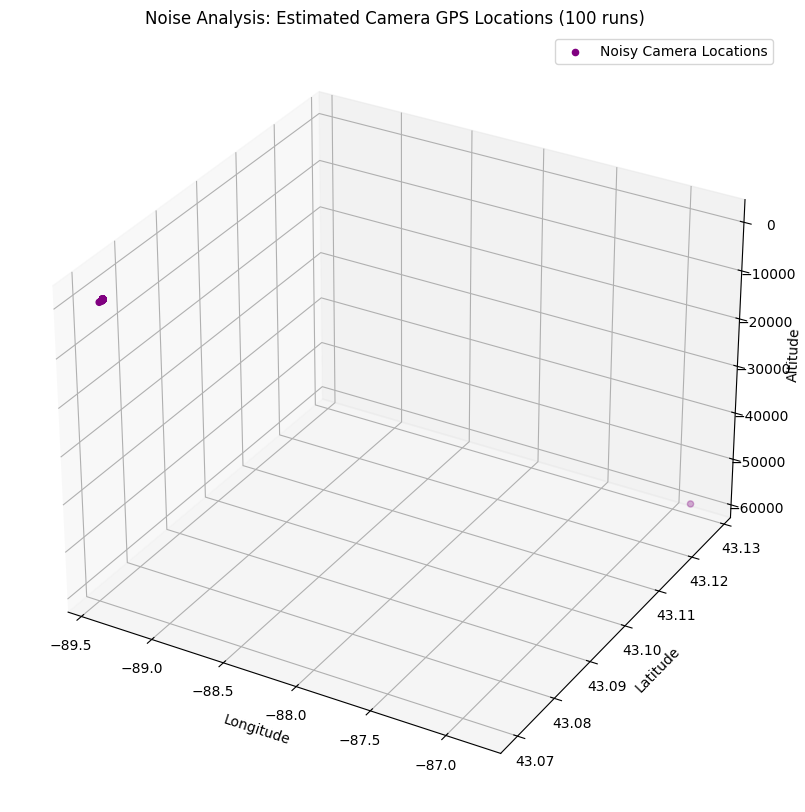

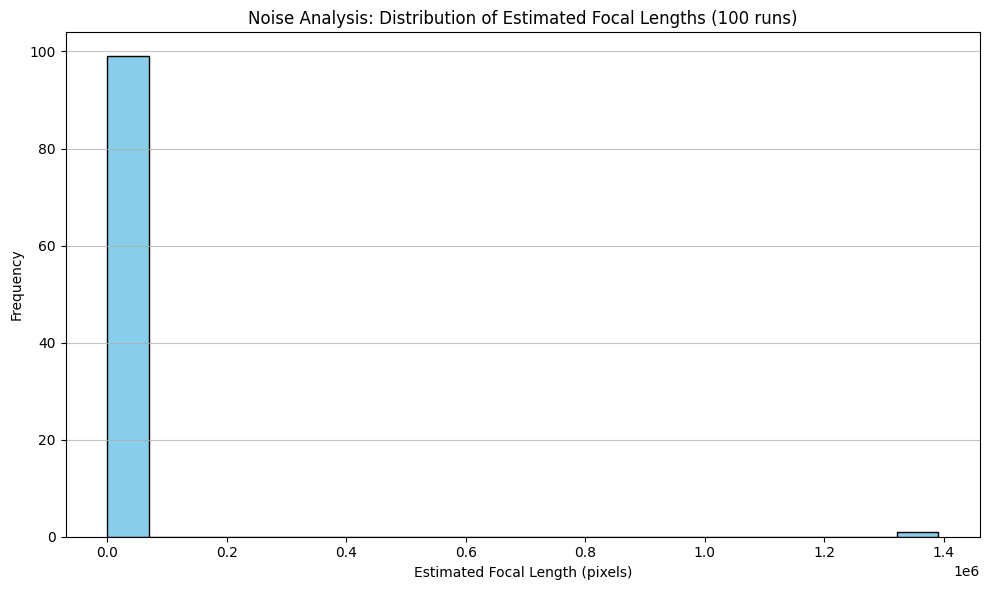

Noise analysis plots displayed.


In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 1. Create a 3D scatter plot of noisy_camera_locations
fig_3d = plt.figure(figsize=(12, 10))
ax_3d = fig_3d.add_subplot(111, projection='3d')

# Extract latitude, longitude, and altitude from noisy_camera_locations
longitudes_noise = noisy_camera_locations[:, 1]
latitudes_noise = noisy_camera_locations[:, 0]
altitudes_noise = noisy_camera_locations[:, 2]

# Plot the noisy camera locations
ax_3d.scatter(longitudes_noise, latitudes_noise, altitudes_noise, c='purple', marker='o', s=20, label='Noisy Camera Locations')

# Add the originally estimated camera GPS location for reference
# camera_gps_pos = camera_enu_to_gps(origin_gps, r_matrix, t_vector)
# ax_3d.scatter(camera_gps_pos[1], camera_gps_pos[0], camera_gps_pos[2], c='red', marker='X', s=100, label='Original Estimated Camera Location', depthshade=False)

# Set labels and title for the 3D plot
ax_3d.set_xlabel('Longitude')
ax_3d.set_ylabel('Latitude')
ax_3d.set_zlabel('Altitude')
ax_3d.set_title('Noise Analysis: Estimated Camera GPS Locations (100 runs)')
ax_3d.legend()

# 2. Create a histogram of the estimated_focal_lengths
plt.figure(figsize=(10, 6))
plt.hist(estimated_focal_lengths, bins=20, color='skyblue', edgecolor='black')

# Set labels and title for the histogram
plt.xlabel('Estimated Focal Length (pixels)')
plt.ylabel('Frequency')
plt.title('Noise Analysis: Distribution of Estimated Focal Lengths (100 runs)')
plt.grid(axis='y', alpha=0.75)

# Display both plots
plt.tight_layout()
plt.show()

print("Noise analysis plots displayed.")

## Final Task

### Subtask:
Summarize the key insights from both the Leave-One-Out and Noise analyses. Explain what the generated point clouds and focal length histogram reveal about the uncertainty and robustness of the camera calibration process. Discuss any observed trends or significant variations.


## Summary:

### Q&A
The Leave-One-Out (LOO) analysis generated a cluster of 6 camera GPS locations, each representing the camera's estimated pose when one of the input points was excluded. The spread of these points visually demonstrates the impact of individual measurement points on the camera's estimated position, highlighting the sensitivity of the calibration to specific input data.

The Noise analysis, simulating 100 iterations with Gaussian noise (1 meter for 3D ENU points and 1 pixel for 2D image points), produced a wider, yet still clustered, distribution of camera GPS locations. This broader spread indicates the inherent uncertainty in the calibration process under noisy conditions, while the clustering suggests a degree of robustness. The histogram of estimated focal lengths showed a relatively narrow and concentrated distribution, revealing that the focal length estimation is comparatively stable and less affected by the introduced noise than the camera's extrinsic pose.

### Data Analysis Key Findings
*   A utility function, `camera_enu_to_gps`, was successfully implemented to convert the camera's estimated pose (rotation and translation from ENU to Camera coordinates) back into GPS coordinates (latitude, longitude, altitude).
*   **Leave-One-Out (LOO) Analysis**:
    *   The LOO analysis involved sequentially removing one point from the `poi_data` (total of 6 points), recalibrating the camera, and then deriving the camera's GPS location. This process resulted in 6 distinct estimated camera GPS locations.
    *   A 3D scatter plot of these 6 locations visually presented the variability and spread in the camera's estimated position due to the exclusion of individual input points.
*   **Noise Analysis**:
    *   A simulation was conducted over 100 iterations, where Gaussian noise (with a standard deviation of 1 meter for 3D ENU points and 1 pixel for 2D image points) was added to the input data before recalibrating the camera.
    *   This analysis generated 100 estimated camera GPS locations and 100 estimated focal lengths.
    *   A 3D scatter plot displayed the distribution of the 100 noisy camera GPS locations, illustrating the overall uncertainty.
    *   A histogram of the 100 estimated focal lengths showed their frequency distribution, indicating the stability of this intrinsic parameter under noise.

### Insights or Next Steps
*   The observed spread in camera GPS locations from both the LOO and noise analyses quantifies the uncertainty in the camera's pose estimation, highlighting the calibration's sensitivity to input data quality and variations. This suggests that precise measurements of Points of Interest are crucial for accurate camera calibration.
*   The relatively tight distribution of focal lengths in the noise analysis indicates that this intrinsic parameter is more robustly estimated compared to the camera's extrinsic pose under noisy conditions. Future analyses could focus on the stability of other intrinsic parameters as well.
